In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mounted at /content/drive
Num GPUs Available:  0


In [ ]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']

In [ ]:
# load base dataframe

import pandas as pd

filepath = "/content/drive/MyDrive/w207/mids_w207_music_genre/member_workspaces/lawrence/mtg_jamendo_genre_melspecs_flattened_base_100.feather"
df_base = pd.read_feather(filepath)

In [ ]:
df_base.head(1)


,metadata_path,stratify,genre_60s,genre_70s,genre_80s,genre_90s,genre_acidjazz,genre_african,genre_alternative,genre_alternativerock,...,melspec_65558,melspec_65559,melspec_65560,melspec_65561,melspec_65562,melspec_65563,melspec_65564,melspec_65565,melspec_65566,melspec_65567
0,20/1208520.mp3,genre_pop,0,0,0,0,0,0,0,0,...,-57.232704,-61.025074,-60.531013,-61.654968,-60.626476,-60.059616,-62.485992,-69.556396,-68.422127,-42.633823


In [ ]:
import numpy as np

def crop_center(melspec,cropx,cropy):
    y,x = melspec.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return melspec[starty:starty+cropy,startx:startx+cropx]

tmp_npy = np.load("/content/drive/MyDrive/w207/w207-team-project/mtg-jamendo-dataset/download/melspecs_npy/20/1208520.npy")
tmp_npy = crop_center(tmp_npy,683,96)


In [ ]:
tmp_npy.flatten().reshape(96, 683)

array([[  3.8465643 ,   7.7637463 ,   9.906768  , ..., -16.307817  ,
        -13.480965  , -12.875347  ],
       [ 10.701651  ,  13.484859  ,  14.178486  , ...,   0.33107704,
          2.2135766 ,  -1.8160089 ],
       [  9.353886  ,  11.737224  ,  11.618745  , ...,   9.819558  ,
         12.105614  ,   8.206997  ],
       ...,
       [-36.118645  , -18.168148  , -19.147749  , ..., -39.207767  ,
        -39.802937  , -32.553387  ],
       [-46.143425  , -24.945555  , -27.619738  , ..., -38.66453   ,
        -37.801727  , -27.80973   ],
       [-60.774845  , -40.43894   , -43.071312  , ..., -69.5564    ,
        -68.42213   , -42.633823  ]], dtype=float32)

In [ ]:
# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np


# get features
FEATURES = [c for c in df_base.columns if c.startswith('melspec_')]
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
print(F"X_train: {X_train.shape}")
print(F"X_test:  {X_test.shape}")

# scale
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train, y_train)
# X_test = scaler.transform(X_test)

# # scale X_train
X_train_mean = np.mean(X_train)
# X_train_max = X_train.max()
# X_train_min = X_train.min()
# X_train_std = (X_train - X_train_min)/(X_train_max - X_train_min)
X_train_std = np.std(X_train)
X_train = (X_train - X_train_mean) / X_train_std

# # scale X_test
# X_test_std = (X_test - X_train_min)/(X_train_max - X_train_min)
X_test = (X_test - X_train_mean) / X_train_std

print(F"X_train: {X_train.shape}")
print(F"X_test:  {X_test.shape}")

X_train: (800, 65568)
X_test:  (200, 65568)
X_train: (800, 65568)
X_test:  (200, 65568)


## Experiment \#1: Shallow network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 10)                655690    
                                                                 
Total params: 655,690
Trainable params: 655,690
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 3s 23ms/step - loss: 136504.4219 - accuracy: 0.1050 - val_loss: 56078.2656 - val_accuracy: 0.1700
Epoch 2/20
19/19 [==============================] - 0s 9ms/step - loss: 123245.7734 - accuracy: 0.1367 - val_loss: 181624.5938 - val_accuracy: 0.1500
Epoch 3/20
19/19 [==============================] - 0s 8ms/step - loss: 100234.8125 - accuracy: 0.1500 - val_loss: 78239.7266 - val_accuracy: 0.1650
Epoch 4/20
19/19 [==============================] - 0s 9ms/step - loss: 95743.0781 - accuracy: 0.1717 - val_loss: 141735.3750 - v

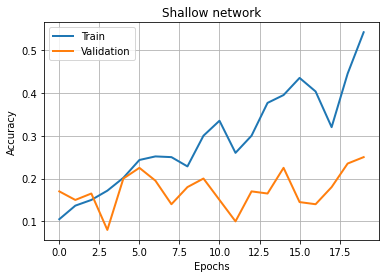

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
model = tf.keras.Sequential()
model.add(
    tf.keras.Input(shape=(65568,), name='Input'))
model.add(
    tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy'])
model.summary()

# fit model
history = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=20)

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("Shallow network")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# get test accuracy
y_pred = np.argmax(model.predict(x=X_test), axis=1)
test_accuracy = accuracy_score(y_test, y_pred)
print(F"Test accuracy: {test_accuracy}")

## Experiment \#2: Deep network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_1 (Dense)             (None, 256)               16785664  
                                                                 
 Layer_2 (Dense)             (None, 128)               32896     
                                                                 
 Layer_3 (Dense)             (None, 64)                8256      
                                                                 
 Layer_4 (Dense)             (None, 32)                2080      
                                                                 
 Layer_5 (Dense)             (None, 16)                528       
                                                                 
 Output (Dense)              (None, 10)                170       
                                                                 
Total params: 16,829,594
Trainable params: 16,829,594
No

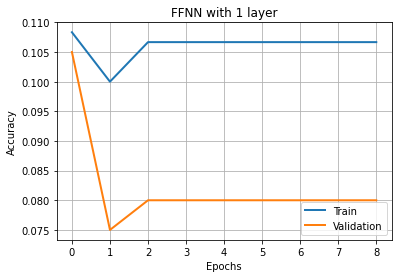

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
model = tf.keras.Sequential()
model.add(
    tf.keras.Input(shape=(65568,), name='Input'))
model.add(
    tf.keras.layers.Dense(units=256, activation='relu', name='Layer_1'))
model.add(
    tf.keras.layers.Dense(units=128, activation='relu', name='Layer_2'))
model.add(
    tf.keras.layers.Dense(units=64, activation='relu', name='Layer_3'))
model.add(
    tf.keras.layers.Dense(units=32, activation='relu', name='Layer_4'))
model.add(
    tf.keras.layers.Dense(units=16, activation='relu', name='Layer_5'))
model.add(
    tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=20, callbacks=[es])

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("FFNN with 1 layer")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# get test accuracy
y_pred = np.argmax(model.predict(x=X_test), axis=1)
train_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
test_accuracy = accuracy_score(y_test, y_pred)
print(F"Train accuracy: {train_accuracy}")
print(F"Validation accuracy: {validation_accuracy}")
print(F"Test accuracy: {test_accuracy}")

# Experiment \#2: CNNs

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 96, 683, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 94, 681, 16)       160       
                                                                 
 flatten (Flatten)           (None, 1024224)           0         
                                                                 
 Output (Dense)              (None, 10)                10242250  
                                                                 
Total params: 10,242,410
Trainable params: 10,242,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 1s 50ms/step - loss: 18.2202 - accuracy: 0.2167 - val_loss: 13.1079 - val_accuracy: 0.2000
Epoch 2/20
19/19 [===============

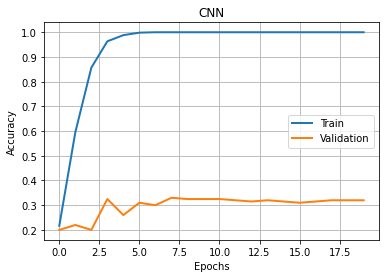

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# clear session + set random seed
tf.keras.backend.clear_session()
# tf.random.set_seed(10)

# build model
model = tf.keras.Sequential()
model.add(
    tf.keras.Input(shape=(65568,), name='Input'))
model.add(
    tf.keras.layers.Reshape((96, 683, 1)))
model.add(
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(
    tf.keras.layers.Flatten()
)
model.add(
    tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=20, callbacks=[es])
# history = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=20)

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# get test accuracy
y_pred = np.argmax(model.predict(x=X_test), axis=1)
train_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
test_accuracy = accuracy_score(y_test, y_pred)
print(F"Train accuracy: {train_accuracy}")
print(F"Validation accuracy: {validation_accuracy}")
print(F"Test accuracy: {test_accuracy}")